# Ensemble: pr (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
xarray.set_options(keep_attrs=True);

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

spatial_text = 'precipitation (solid) net pr (dashed) over sea-ice and ocean'
spatial_units = 'mm day⁻¹' # base units kg m-2 s-1

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 2.5)
time_series_y_range_full = (0, 3.5)
time_series_y_range_monthly = (0, 3)
time_series_y_range_regional = (0, 5)
time_series_process = lambda x: x

colormesh_kwargs = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 3.6,
    'x': 'longitude', 
    'y': 'latitude'
}

colormesh_kwargs_sep = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 3.6,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

In [4]:
conf_evspsbl = [v for v in libs.vars.variables() if v['variable_id'] == 'evspsbl'][0]
ensemble_evspsbl, weight_evspsbl = libs.ensemble.get_and_preprocess(
    'Amon', 
    experiment, 
    'evspsbl',
    preprocess=conf_evspsbl['preprocess']
)

data_vars = {}
for item in ensemble:
    item_mask = [item_mask for item_mask in ensemble_evspsbl if item_mask['label'] == item['label']]
    if len(item_mask) == 0:
        continue
        
    item_mask = item_mask[0]['data']
    processed_data = item['data']
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')

    item_weighted = (processed_data - item_mask).weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True)
    item_reduced.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    
    data_vars[item['label']] = item_reduced

ds_prnet = xarray.Dataset(data_vars=data_vars)
ds_prnet = libs.ensemble.calc_variable_mean(ds_prnet)
ds_prnet['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

## Time series

### Mean

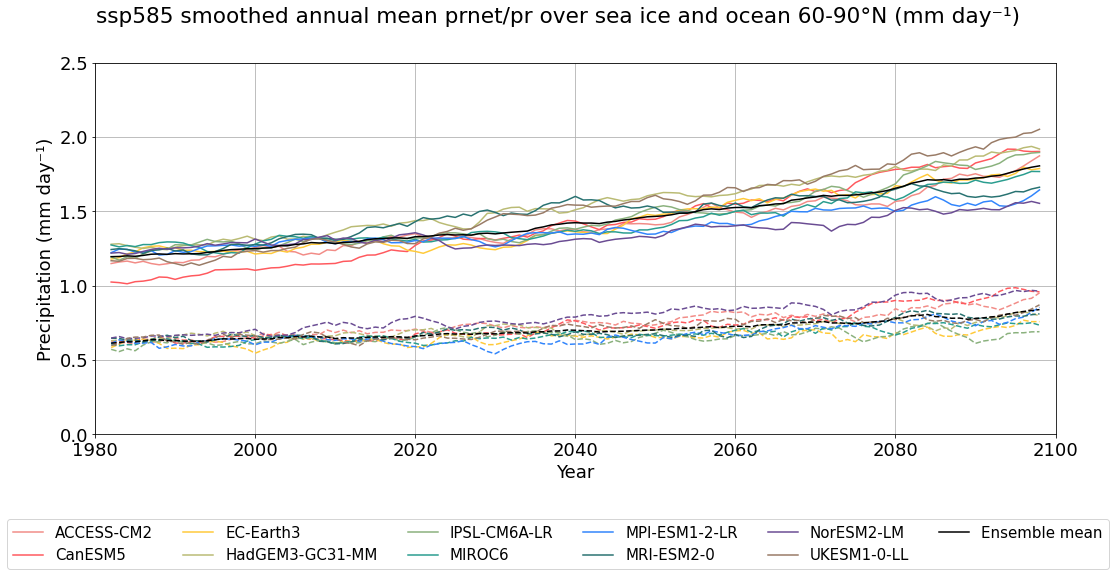

In [5]:
vars_series = [
    ensemble_time_series,
    ds_prnet
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean prnet/pr over sea ice and ocean 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

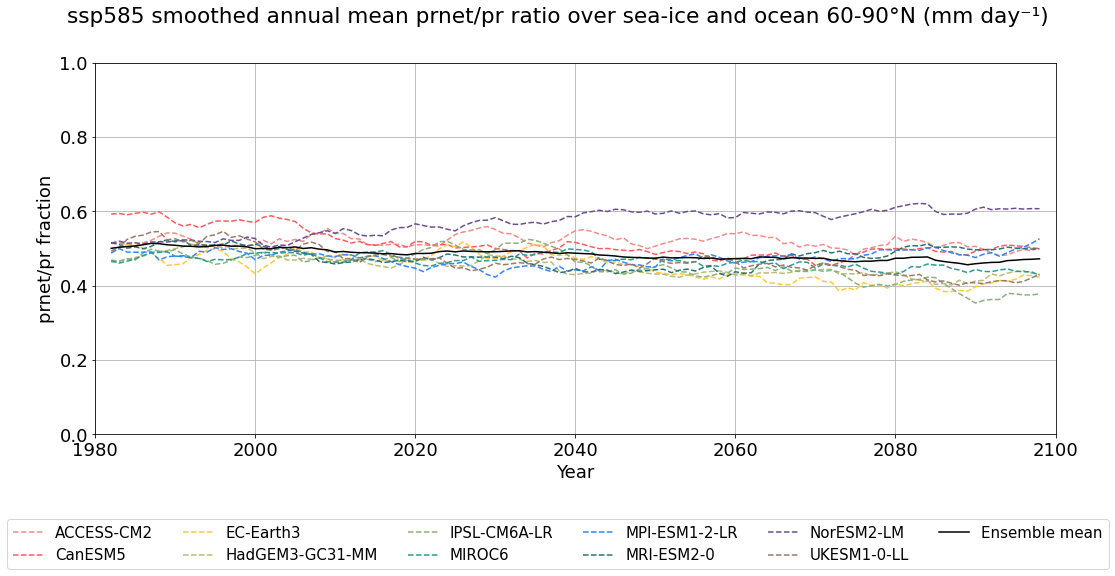

In [6]:
vars_series = [
    ds_prnet / ensemble_time_series,
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

#plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean prnet/pr ratio over sea-ice and ocean 60-90°N ({time_series_units})',
    xattr='year',
    ylabel='prnet/pr fraction',
    yrange=(0, 1)
);

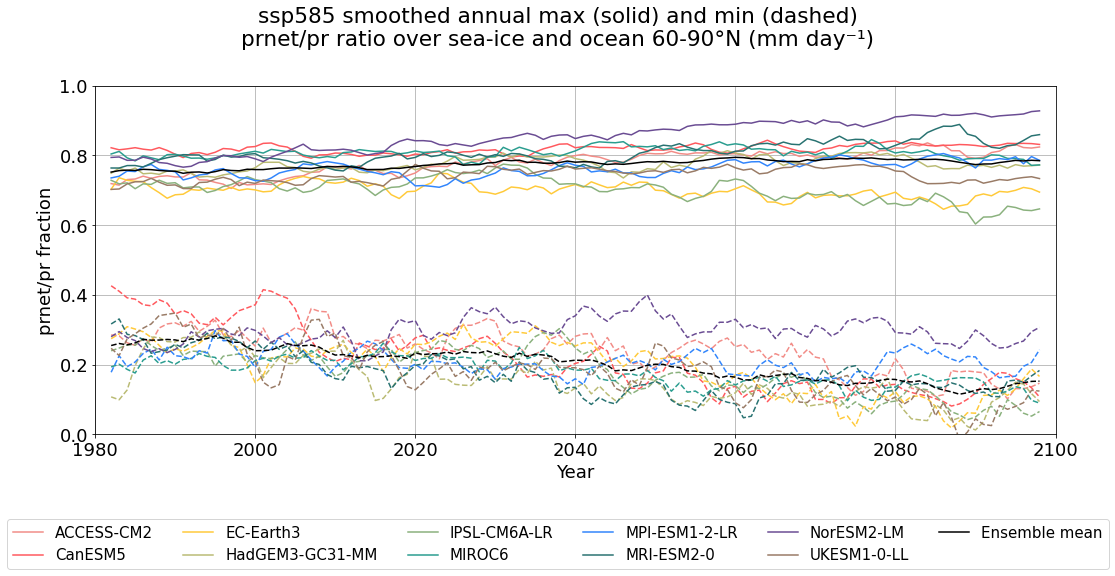

In [7]:
vars_series = [
    ds_prnet / ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').max('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    for key in item_processed: 
        item_processed[key].attrs['plot_kwargs'] = { 'linestyle': 'solid' }
    plot_arr.append(item_processed)
    
    item_processed = item.groupby('time.year').min('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    for key in item_processed: 
        item_processed[key].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual max (solid) and min (dashed)\nprnet/pr ratio over sea-ice and ocean 60-90°N ({time_series_units})',
    xattr='year',
    ylabel='prnet/pr fraction',
    yrange=(0, 1)
);

### Full variability

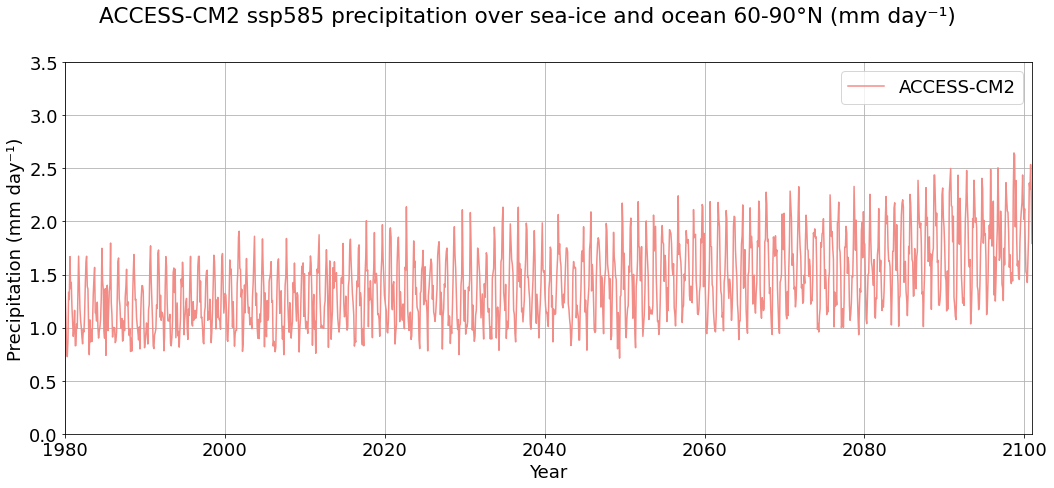

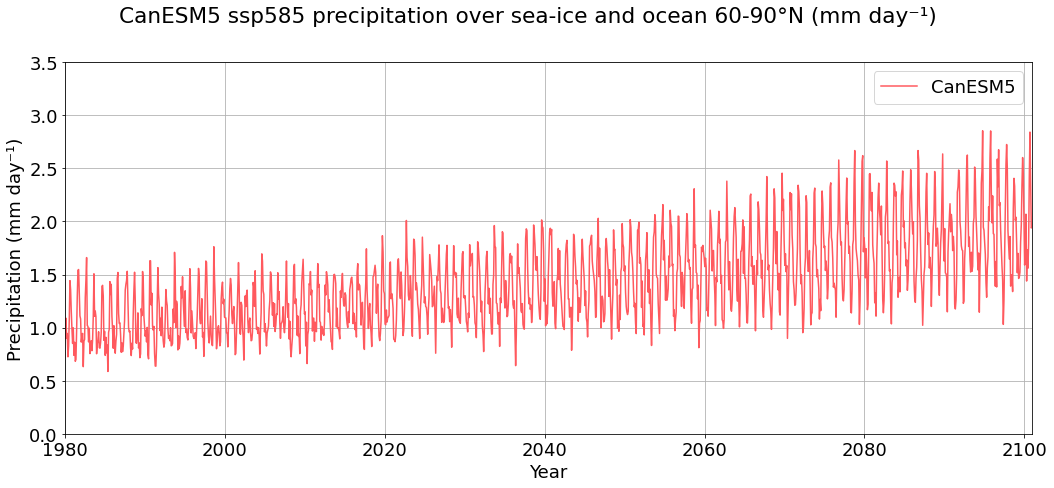

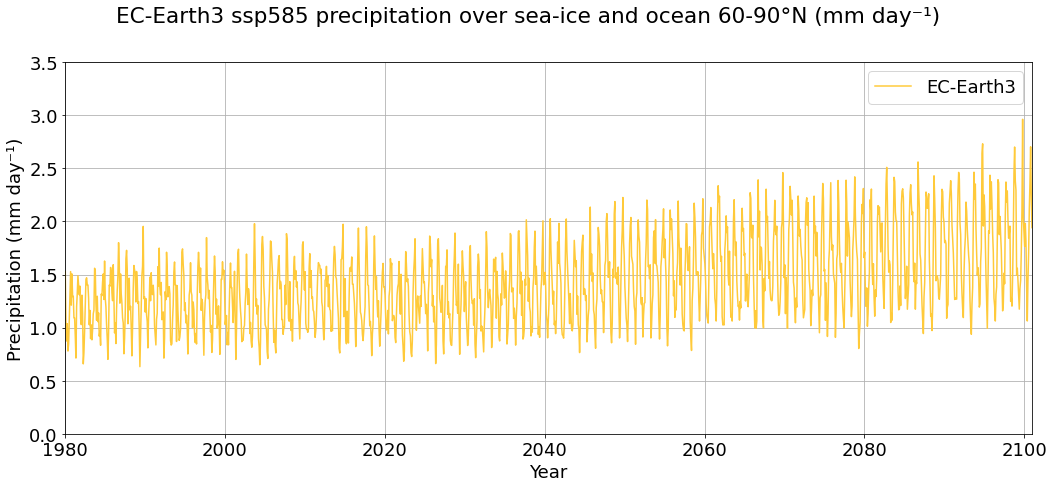

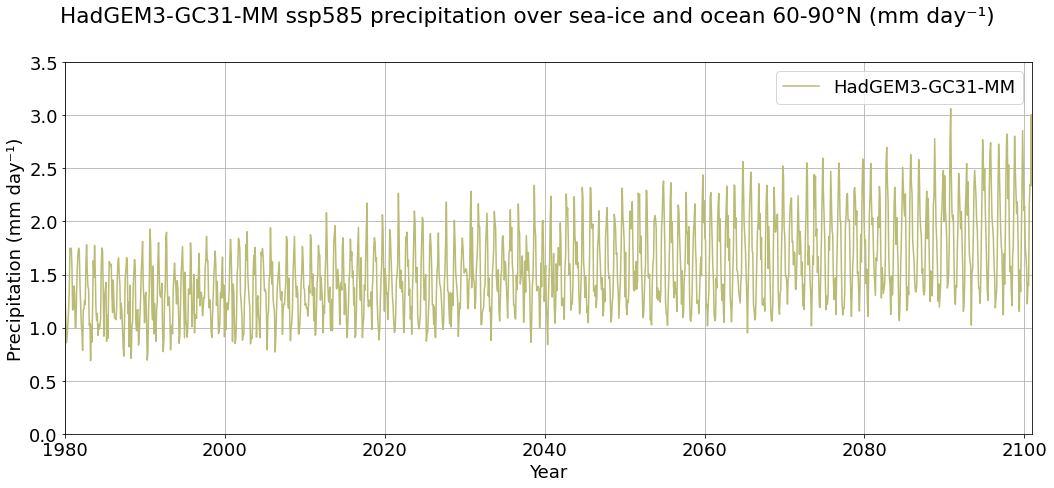

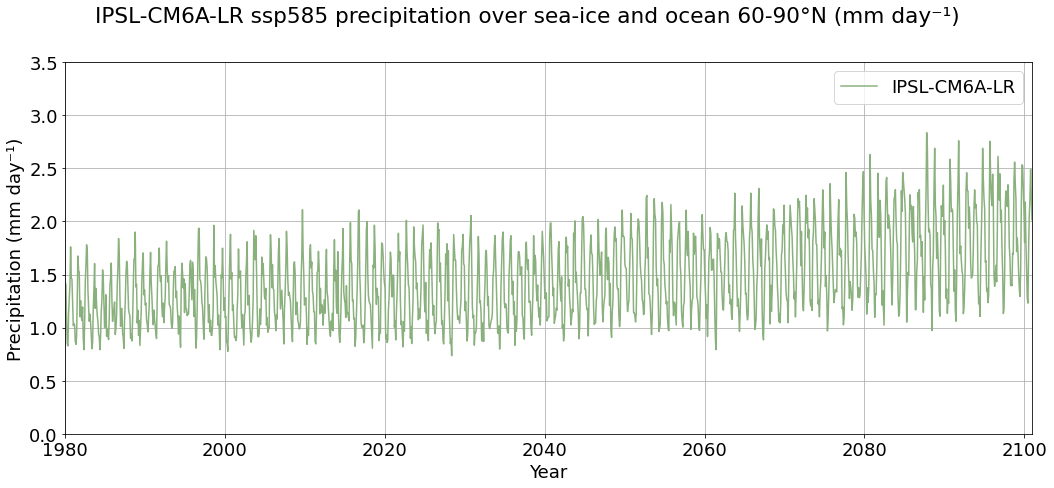

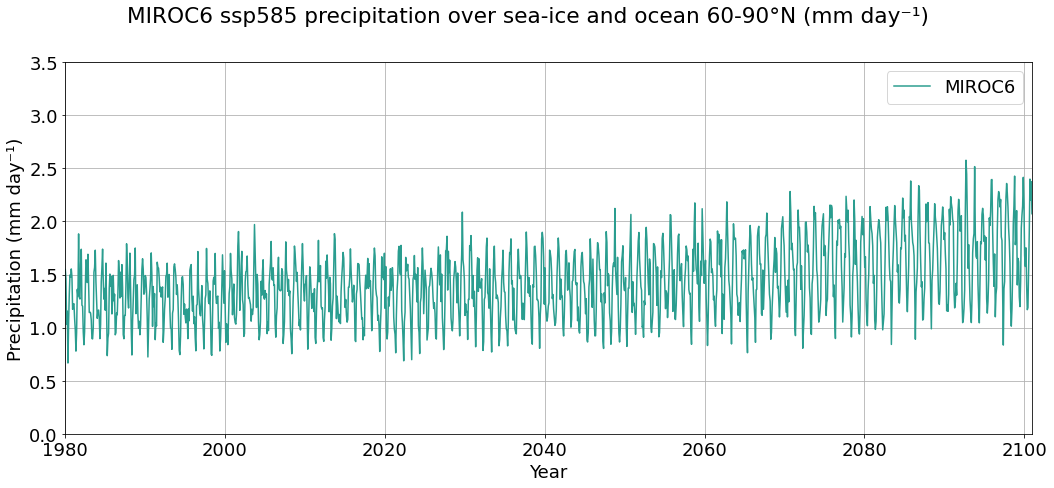

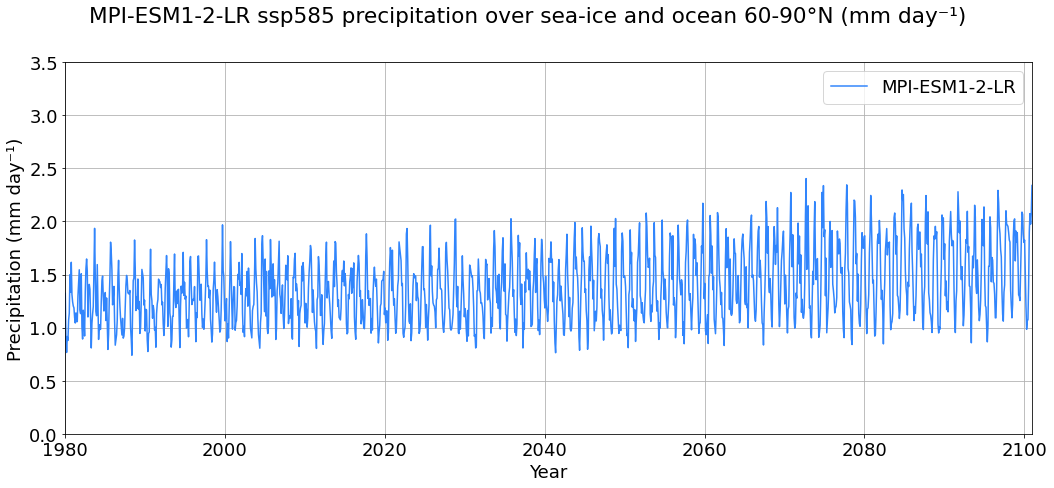

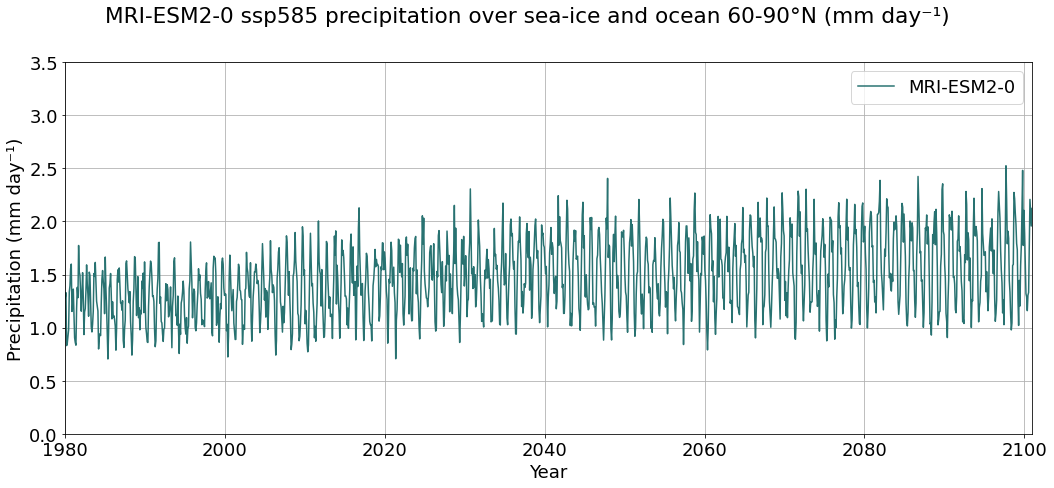

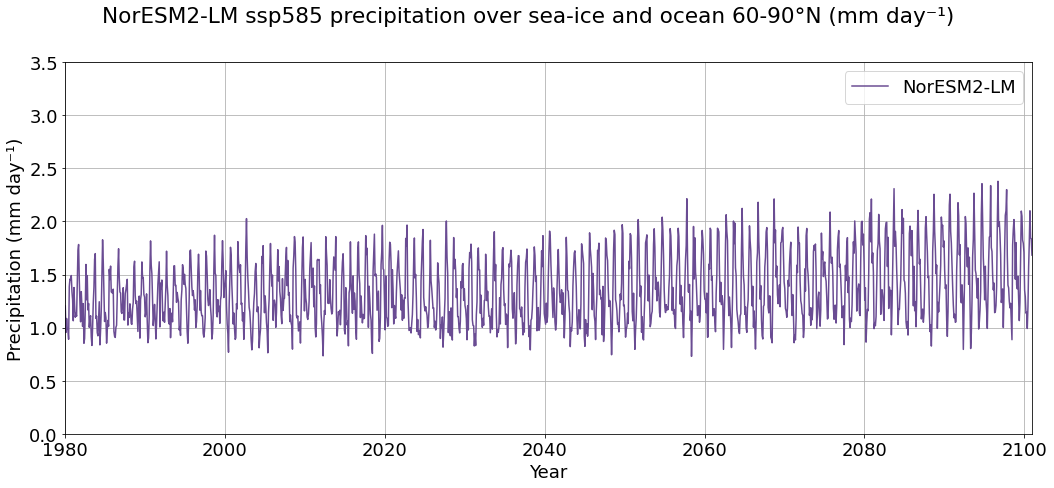

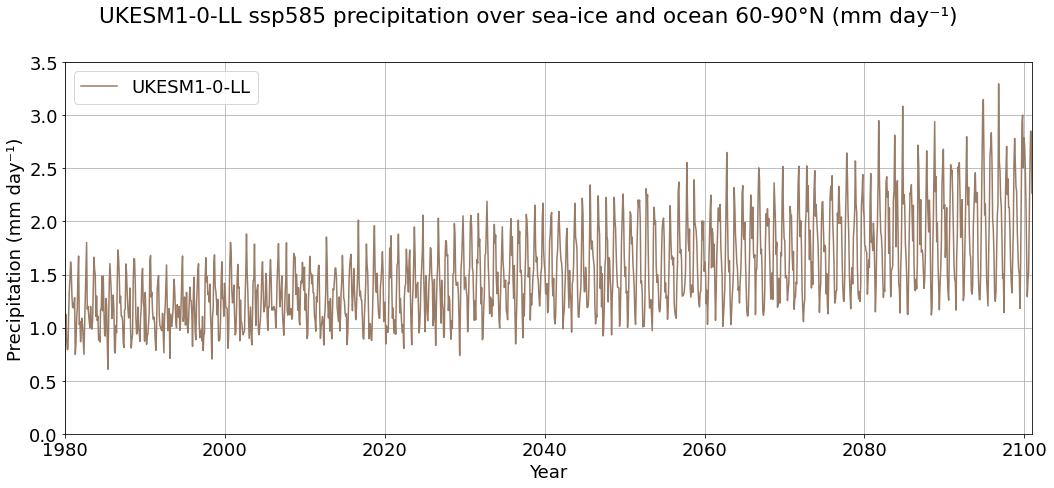

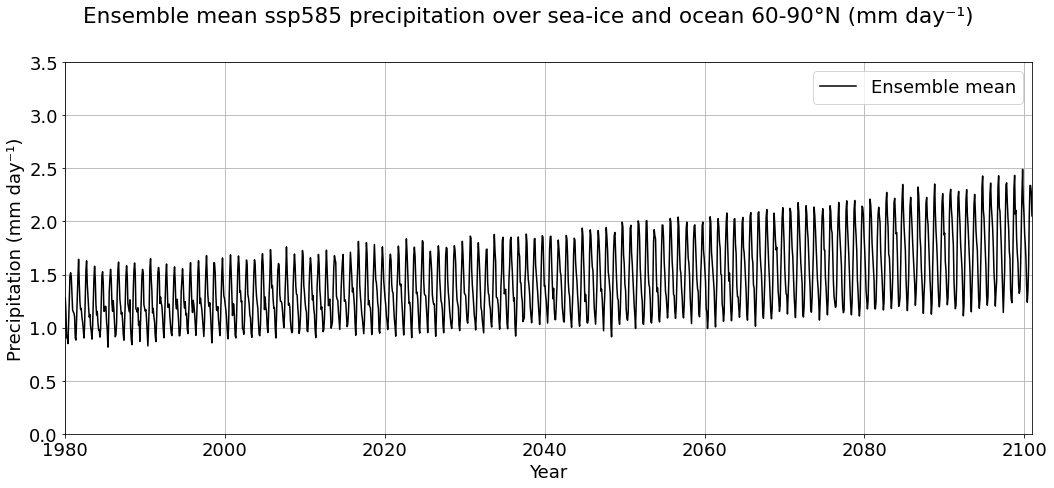

In [8]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

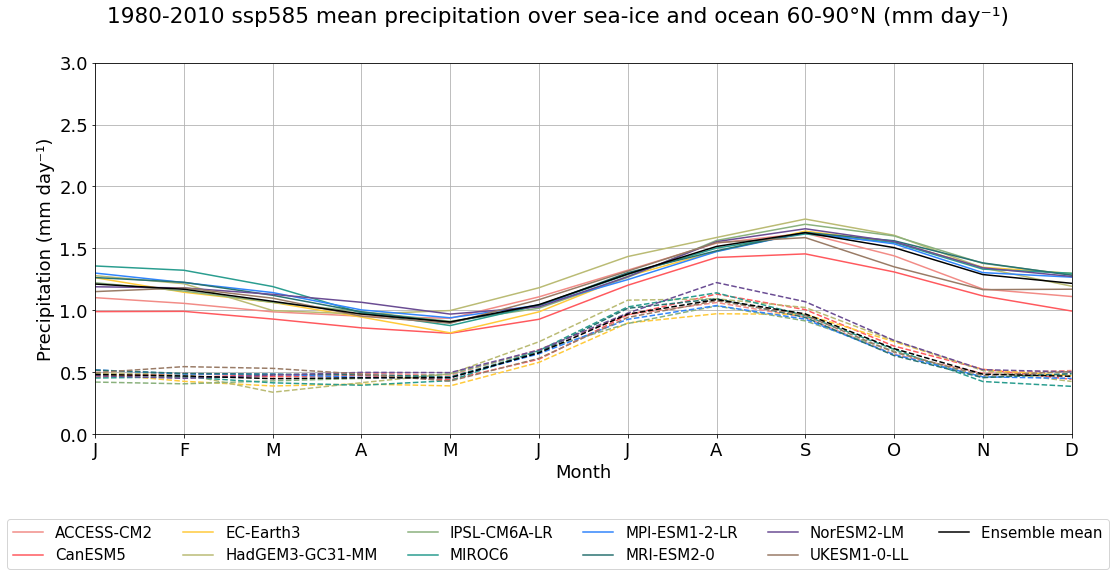

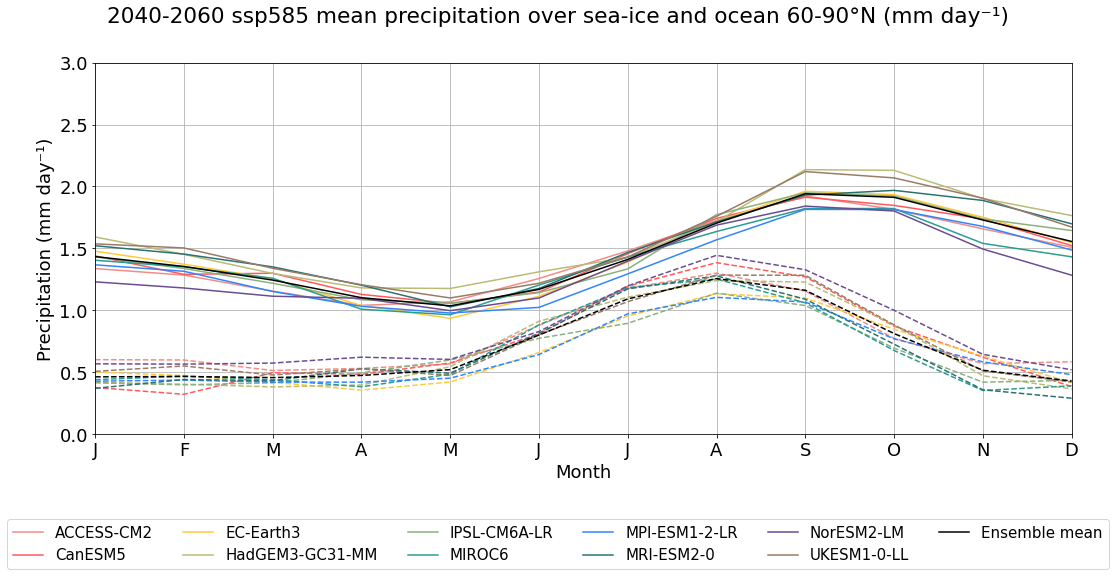

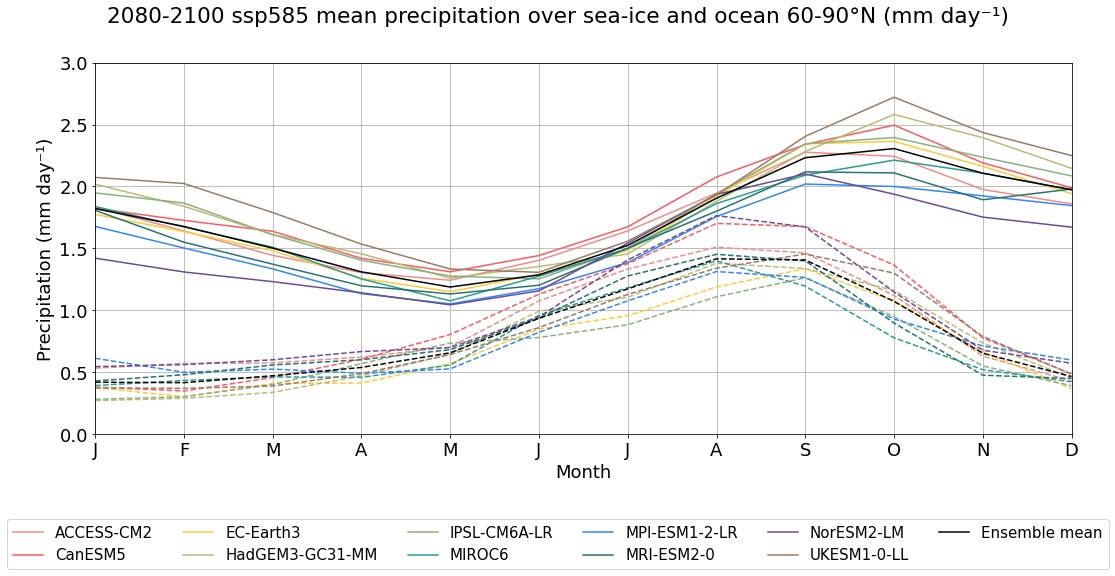

In [9]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        [
            ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ds_prnet.sel(**s['slice']).groupby('time.month').mean('time')
        ],
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional (time)

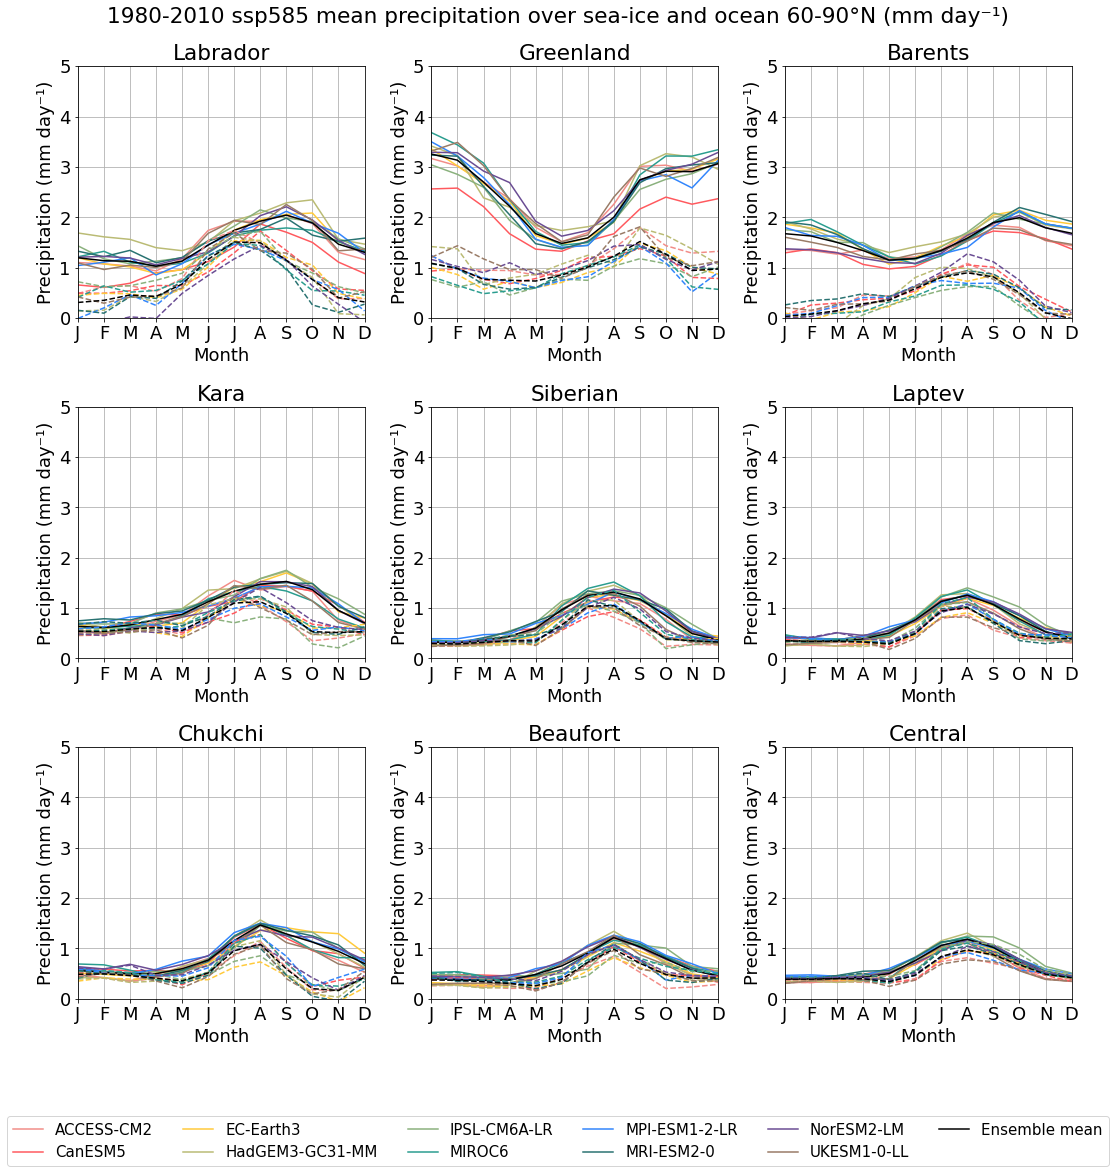

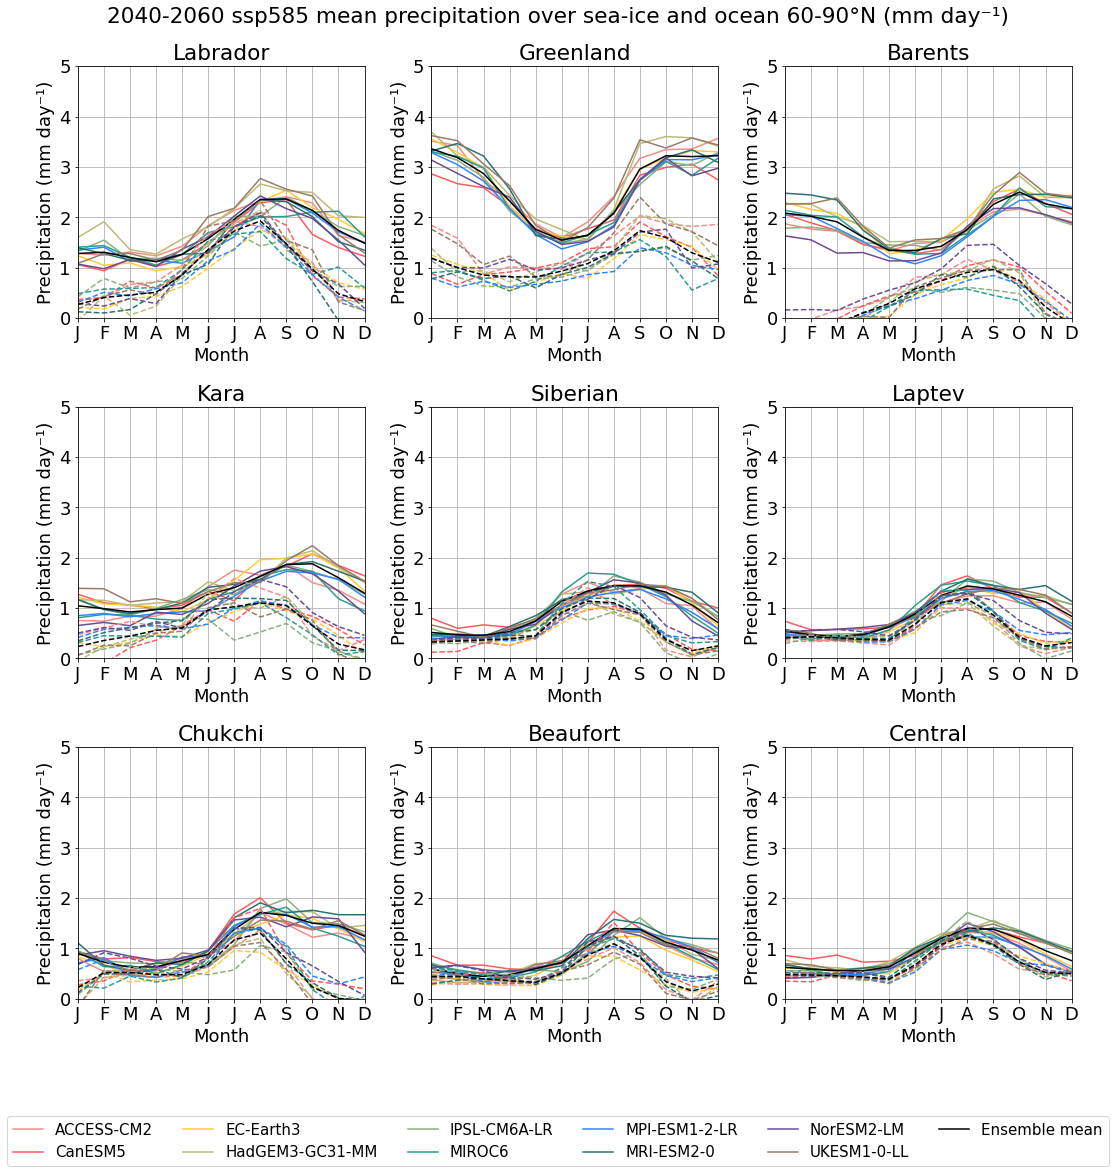

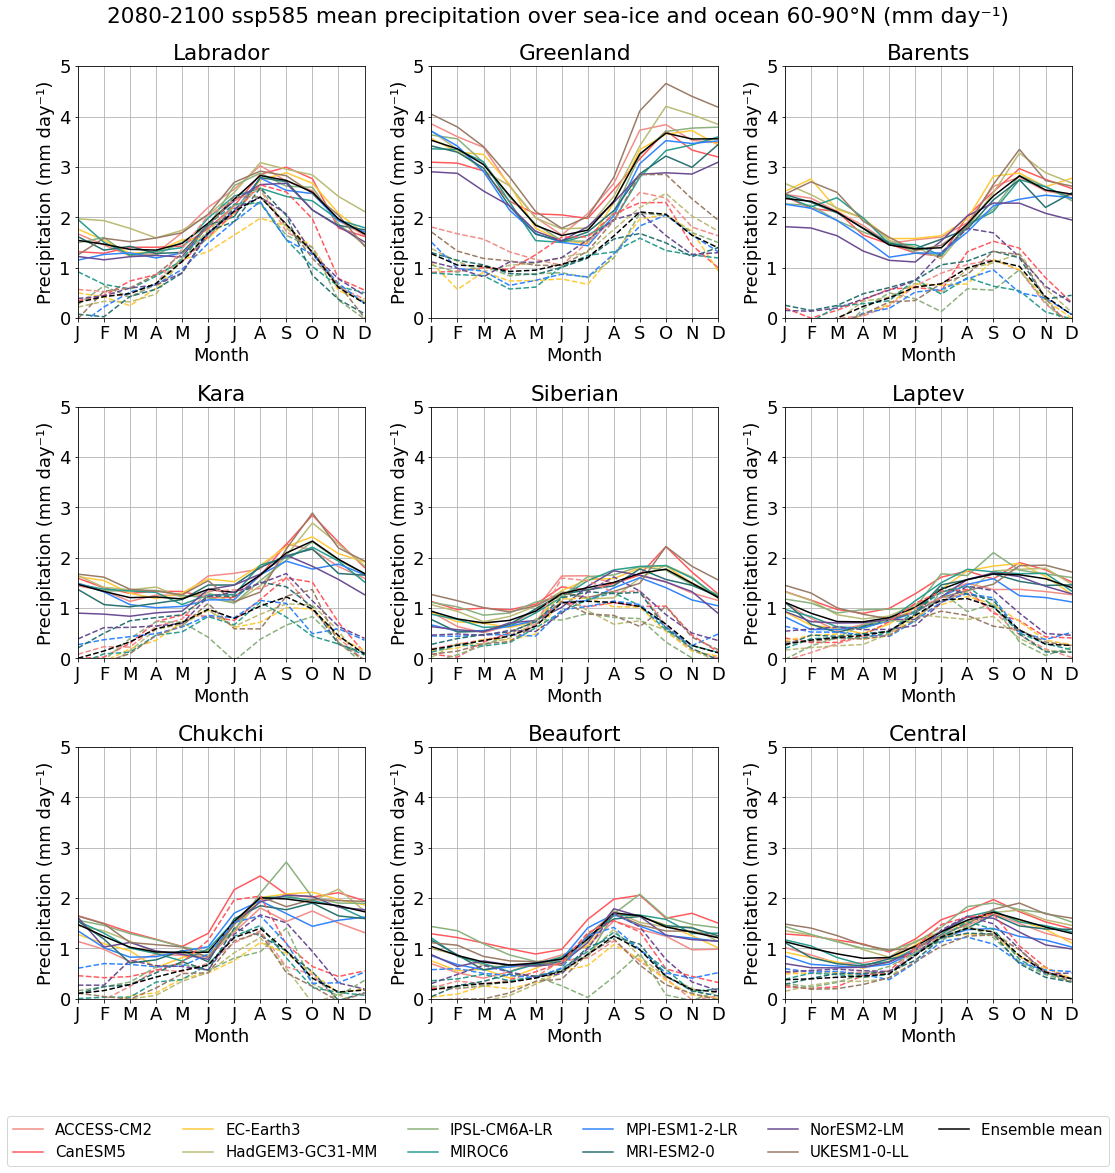

In [10]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)
regions_prnet = libs.local.get_ensemble_regional_series('prnet', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data in enumerate(regions):
        data_prnet = regions_prnet[i].sel(**s['slice']).groupby('time.month').mean('time')
        for key in data_prnet:
            data_prnet[key].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
        
        arr.append([
            data.sel(**s['slice']).groupby('time.month').mean('time'),
            data_prnet
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Regional prnet/pr ratio

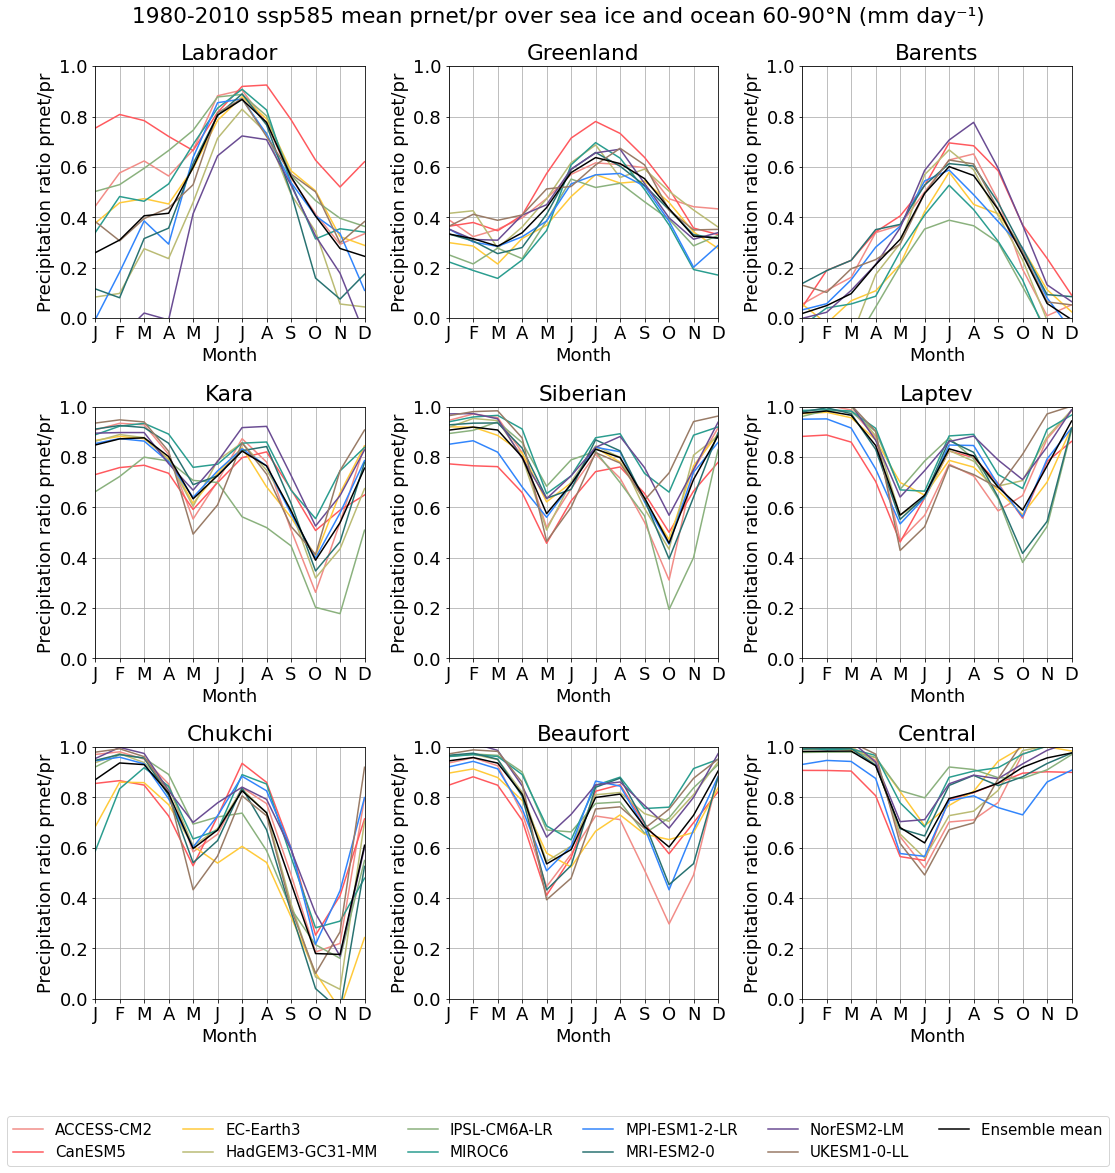

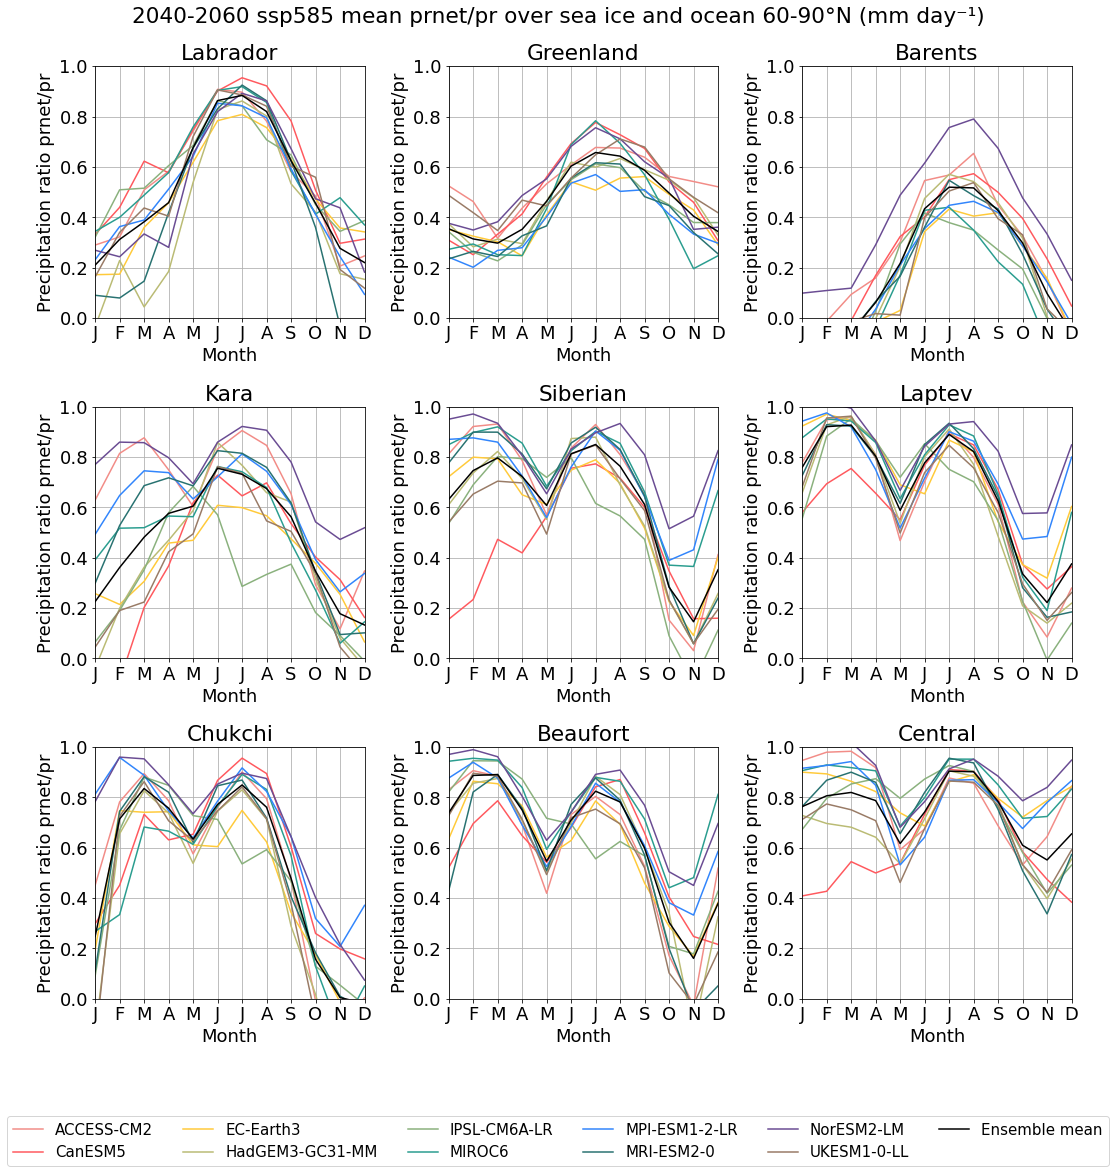

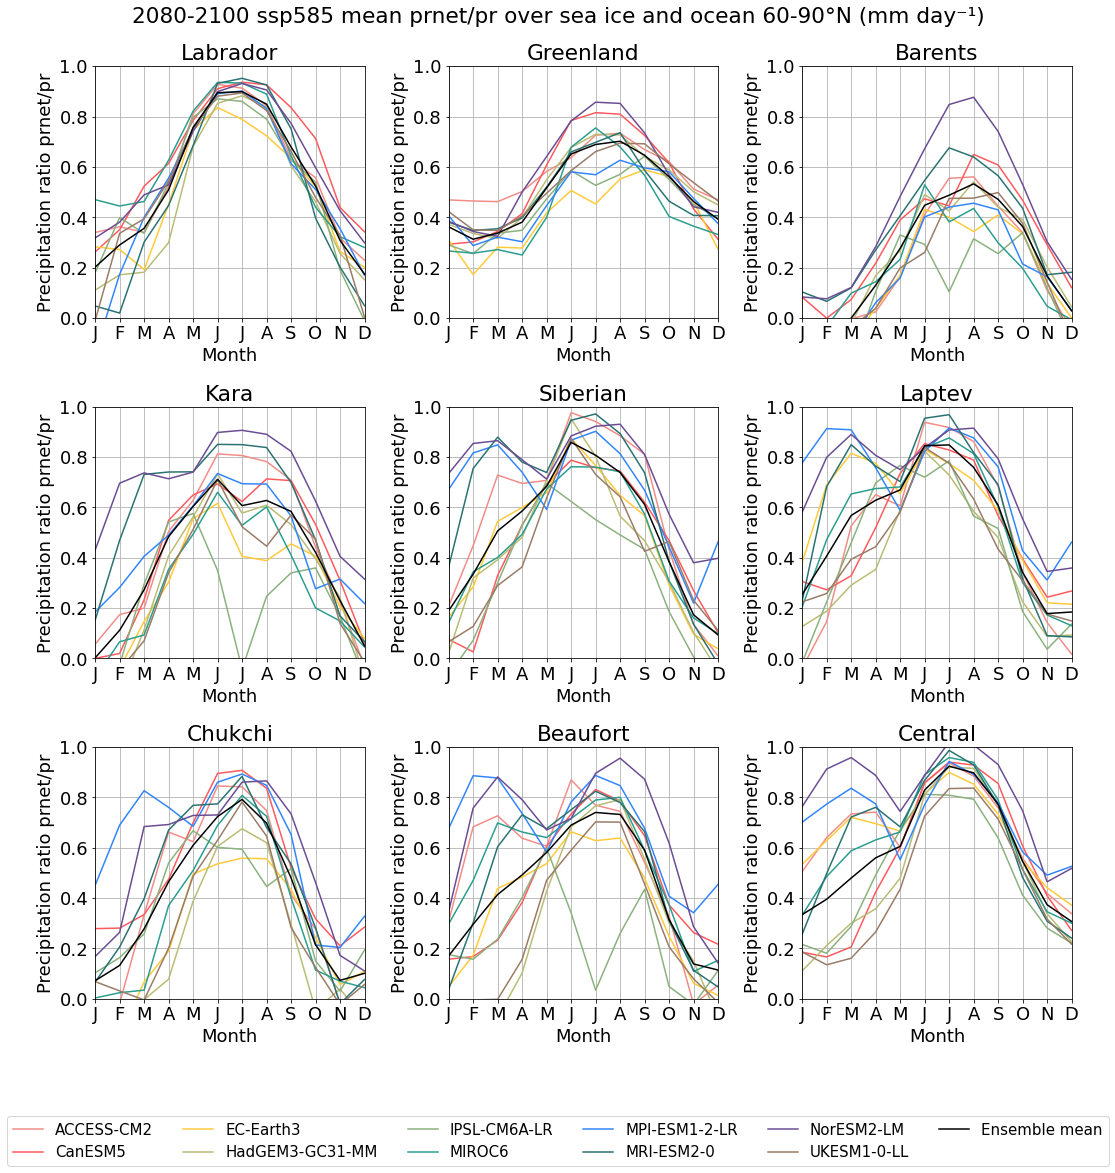

In [11]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)
regions_prnet = libs.local.get_ensemble_regional_series('prnet', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data in enumerate(regions):
        data_prnet = regions_prnet[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_ratio = data_prnet / data_pr
        data_pr_ratio.attrs = data_prnet.attrs
        arr.append([
            data_pr_ratio
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean prnet/pr over sea ice and ocean 60-90°N ({time_series_units})',
        ylabel='Precipitation ratio prnet/pr',
        yrange=(0, 1)
    )